In [1]:
%load_ext autoreload
%load_ext ipycache

/usr/local/lib/python2.7/dist-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/usr/local/lib/python2.7/dist-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
%autoreload 2

In [3]:
slow=True

import sys
import fastfilt as ff
import numpy as np
import matplotlib.pyplot as plt
import finder_interface as fi
import pulse_gen as pg
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

The finder interface provides most of the functionallity for the pulse finder. The fast-filt library is used sparingly. The motivation of this notebook will be the generation of the spectra of the SiPM dark count, and then adjusting the pulse finder so that the spectrum can be resolved for very high dark count rates. The first step will be the visualization of the collected data. The specific URI for the data may vary as the library is not hosted with the data. For the dev build the follow URI is used to access the data. 

In [4]:
data_dir="../data/"

The reader is a simple class that is opened by generating the object with a file name and a block size paramter. The default block size is 5000 samples, which at a sampling rate of 500Mhz gives us $10\mu s$ of data. During some data runs more than 5000 samples were taken, however the sizes of various data runs may have been forgotten. The demo data is from wave280.txt which was taken usen a bias voltage of 28.0 volts. 

In [5]:
fig=plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
test_dat_reader=fi.reader(data_dir+'wave280.txt',5000)
blocks=[test_dat_reader.get_block() for i in xrange(5)]
_=plt.plot(blocks[1])
test_dat_reader.close()

In [6]:
f_test="smooth_pulse.txt"
finder=fi.pulse_finder(f_test,old_read=False)
pulses=finder.find_pulses(blocks[1])
for p in pulses:
    print len(pulses)
    _=plt.plot(p)

1


The following shows the first stage of the pulse finder. The matched filter using the template provided in the creation of the pulse finder object. The blue is the collected data and the green curve is the value of the matched filter. A clear peak can be resolved around what appears to be a dark count. The aliasing distortions that can be seen in the blue curve come from the effect of the low pass filter which is used before the matched filter. The signal from the low pass filter is subtracted out from the measured signal in order to cancel out baseline shifts. 

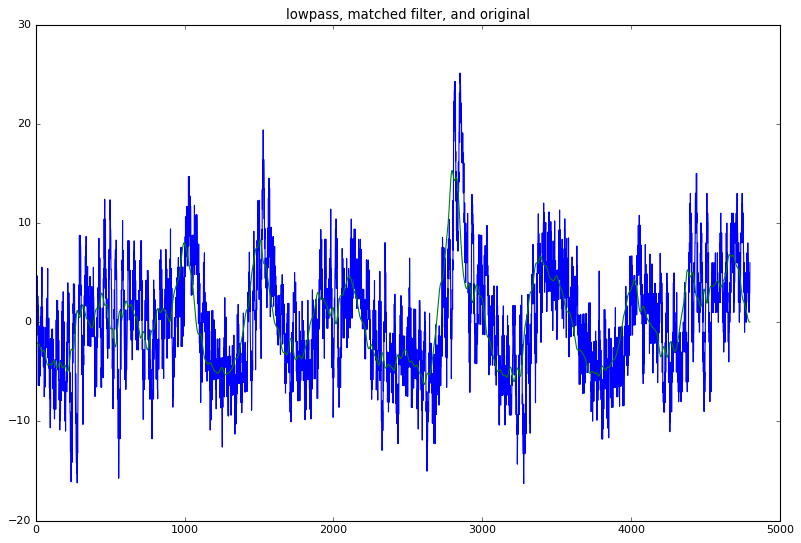

In [7]:
fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
finder.filter_sample(blocks[1],display=True)

In [8]:
%%capture
#this cell is slow to run
gen_dark=False
if gen_dark:
    test_dat_reader=fi.reader(data_dir+'wave280.txt',20000)
    new_dark=fi.re_average(test_dat_reader,finder,1000,limit=20.0)
    test_dat_reader.close()
    t_f_wav=pg.f_wav(data_dir+"low_stat_280_pulse.txt")
    t_f_wav.write(new_dark)
else:
    t_f_wav=pg.f_wav(data_dir+"low_stat_280_pulse.txt")
    new_dark=t_f_wav.read()
    

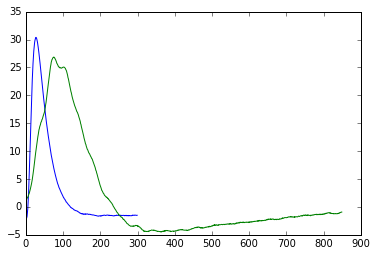

In [9]:
sipm_dark_default=pg.f_wav('smooth_pulse.txt').read()
_=plt.plot(sipm_dark_default)
_=plt.plot(new_dark)

It can be seen from the high trigger results that smooth pulse matched filter is not well adjusted for the actual pulse shape observed in the 6x6mm arrays. In order to accomodate this a new file will be generated that captures the true shape. The subtle oscilations were explained at some point in the path but the reason has been forgotten. The next slide shows the fast_filt pronay analysis being tuned to find a suitable approximation for the measured dark count. 

4 4365.39447548897
6 6140.680950845981
8 5462.259971764372
10 22627.258259382714
12 29029.84473281926
14 20211.191250367945


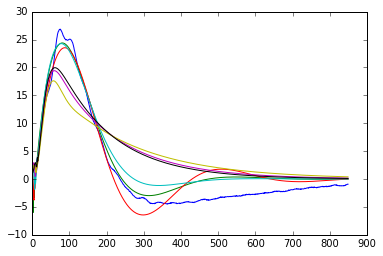

In [10]:
imp=np.asarray([1]+[0]*849)
filts=[]
plt.plot(new_dark)
for i,c in enumerate(xrange(4,16,2)):
    filts.append(ff.prony_shank(new_dark,c,c))
    aprox=filts[i].filter(imp)
    plt.plot(aprox)
    print c,np.sum( (aprox-new_dark)**2 )
    

It can be seen that the initial fit is rather poor. This is due to the inherent numerical instabillity in Prony analysis. For a better fit the magical paramter in the prony_shank function, sForm should be used. I am more than happy to discuss with any interested parties how the sForm parameter produces better fits. 

4 10267.33503610798
6 4519.788340740048
8 4437.017154180553
10 4314.536638774084
12 2270.7812477082402
14 218.50408520667105


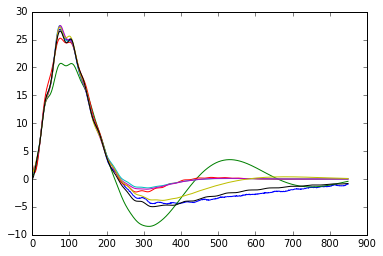

In [11]:
filts=[]
plt.plot(new_dark)
for i,c in enumerate(xrange(4,16,2)):
    filts.append(ff.prony_shank(new_dark,c,c,sForm=10))
    aprox=filts[i].filter(imp)
    plt.plot(aprox)
    print c,np.sum( (aprox-new_dark)**2 )
new_filt=ff.prony_shank(new_dark,14,14,sForm=10)

Viewed in isloation we can see the good fit between the measured pulse in blue and recreated IIR fit. 

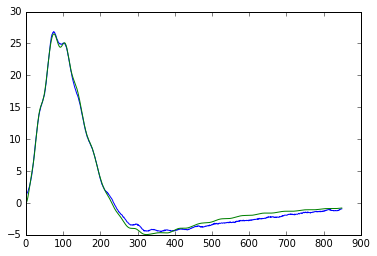

In [12]:
plt.plot(new_dark)
plt.plot(new_filt.filter(imp))

Viewing the above shape we can see that the mean pulse shape is rather long, on the order 1.6$\mu s$. Combined with the relatively high high dark count rate of 50$khz/mm^2$ or 1.8mhz it is unlikely to see any pulses without pile up, and hence the single dark count spectrum will seriously distorted. The portion of dark counts that will have no interfering dark counts in the previous or following 1.6$\mu s$ will be $\exp[-{2*1.6{\mu s}*1.8{MHz}}]=.3\%$

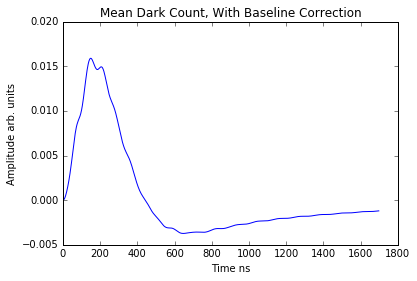

In [13]:
test_dat_reader=fi.reader(data_dir+'wave280.txt',5000)
blocks=[test_dat_reader.get_block() for i in xrange(10)]
#nfinder=fi.pulse_finder(data_dir+"low_stat_280_pulse.txt",old_read=False)
nfinder=fi.pulse_finder(data_dir+"low_stat_280_pulse.txt",old_read=False,pn=14,zn=14,sForm=10,skip=0,total_l=850)
plt.plot(range(0,1700,2),nfinder.iir_filt.filter(imp))
plt.xlabel("Time ns")
plt.ylabel("Amplitude arb. units")
plt.title("Mean Dark Count, With Baseline Correction")
test_dat_reader.close()


The creation of the pulse finder has many parameters. In the future this process might be simplified by allowing for the creation of a JSON file which includes the finder parameters with the pulse shape. The relevant parameters are strongly connected to the pulse shape used. This would also have the benefit of creating a consistent api for the pulse finder parameters. 

In [14]:
pa=nfinder.find_pulses(blocks[0])
lpa=nfinder.find_pulses(blocks[0],block_time=800)
for block in blocks[:5]:
    all_pulses=nfinder.find_pulses(block)
    lone_pulses=nfinder.find_pulses(block,block_time=800)
    print len(all_pulses),len(lone_pulses)

4 1
4 0
4 4
4 2
6 0


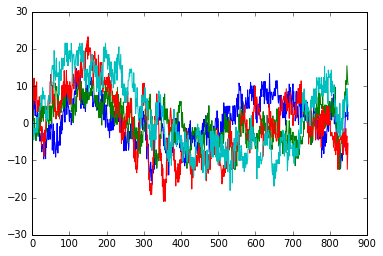

In [15]:
for p in pa:
    _=plt.plot(p)

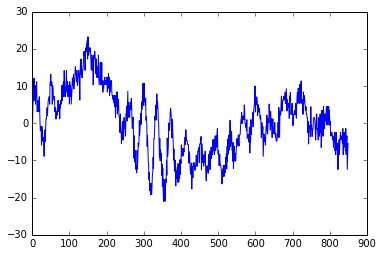

In [16]:
_=plt.plot(lpa[0])

We see a siginificant thinning in the number of registered pulses, maybe not as much as expected but sufficient to blur the spectrum. The following cell will generate files with all of the found pulses. This should only be run sparingly to generate the files. 

In [17]:
#TODO run with this true
find_pulses_a=False
wn1=data_dir+"280_pulses_all.txt"

if find_pulses_a:
    test_dat_reader=fi.reader(data_dir+'wave280.txt',20000)
    nfinder.get_all_pulse(test_dat_reader,wn1,display=True)
    test_dat_reader.close()

find_pulses_b=False
wn2=data_dir+"280_pulses_all_thinned.txt"
if find_pulses_b:
    test_dat_reader=fi.reader(data_dir+'wave280.txt',20000)
    nfinder.get_all_pulse(test_dat_reader,wn2,display=True,block_time=800)
    test_dat_reader.close()

In [18]:
rfn=data_dir+'280_pulses_all_thinned.txt'
ev=np.asarray([0]*50+[1]*200+[0]*600)
resp=new_filt.filter(imp)
efunc1=lambda x:np.dot(x,ev)
efunc2=lambda x:np.max(new_filt.filter(np.flip(x,0)))
efunc3=lambda x:np.dot(x,resp)

In [19]:
%%cache thin_spec.pkl thin_spect 
thin_spect=fi.spectrum(rfn,efunc2)

[Skipped the cell's code and loaded variables thin_spect from file '/home/ryan/Desktop/pulse/pulse model/thin_spec.pkl'.]


147376


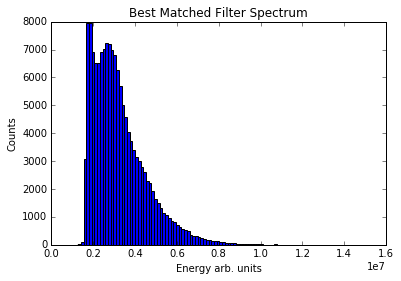

In [20]:
print len(thin_spect)
fig=plt.hist(thin_spect,bins=100)
plt.savefig(data_dir+"spectrum.png")
plt.ylabel("Counts")
plt.xlabel("Energy arb. units")
plt.title("Best Matched Filter Spectrum")

In [21]:
alfn=rfn=data_dir+'280_pulses_all.txt'

In [22]:
%%cache aspect.pkl aspect
aspect=fi.spectrum(alfn,efunc2)

[Skipped the cell's code and loaded variables aspect from file '/home/ryan/Desktop/pulse/pulse model/aspect.pkl'.]


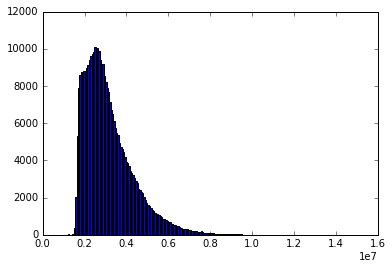

In [23]:
_=plt.hist(aspect,bins=200)

In [24]:
hand_scans=[]
with open(rfn) as f:
    i=0
    for x in f:
        v=x.split(' ')
        v=np.asarray(map(lambda x:int(x),v))
        e=efunc2(v)
        if 2.4e6<e<2.8e6:
            hand_scans.append(v)
        if len(hand_scans)>10:
            break

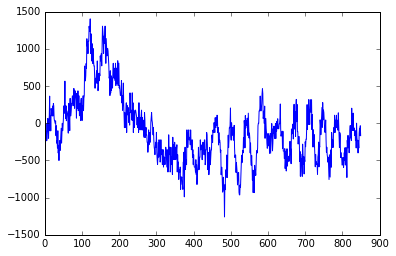

In [25]:
#_=plt.plot(hand_scans[2])
_=plt.plot(np.mean(np.asarray(hand_scans[0:3]),0))

This is an isolated dark count that was measured from the energy peak. It can be observed that the noise present is not white, but rather has a dominating frequency component. During the data taking run it was deduced that this noise was caused by a switching power supply near the dark box that contained the SiPM. Thankfully matched filters can take into account non white noise. In order to this we need samples of the noise without he presence of an SiPM dark count. 

In [26]:
noises=[]
lim=100
test_dat_reader=fi.reader(data_dir+'wave280.txt',20000)
for i in xrange(lim):
    noises+=nfinder.find_noise(test_dat_reader.get_block(),800,50,limit=3,lower=2)
test_dat_reader.close()
print len(noises)


8


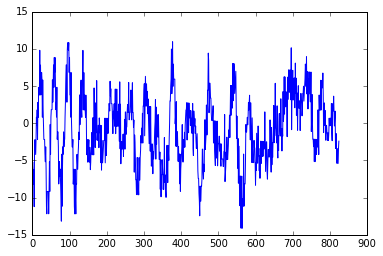

In [27]:
plt.plot(noises[0])

825


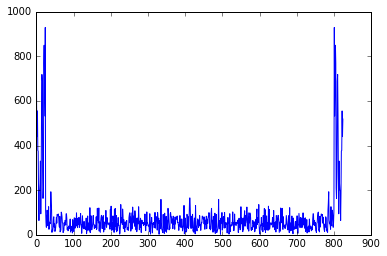

In [28]:
ft2=np.abs(np.fft.fft(noises[0]))
_=plt.plot(ft2)
print len(ft2)

In [29]:
%%cache noise_spec.pkl noise_spec
test_dat_reader=fi.reader(data_dir+'wave280.txt',20000)
noise_spec=(nfinder.integrate_noise(test_dat_reader,850,20,N=1000,limit=3,lower=2,display=True,mode="fft"))
test_dat_reader.close()

[Skipped the cell's code and loaded variables noise_spec from file '/home/ryan/Desktop/pulse/pulse model/noise_spec.pkl'.]


In [30]:
fft=lambda x:np.fft.fft(x)
ifft=lambda x:np.fft.ifft(x)

(0, 200)

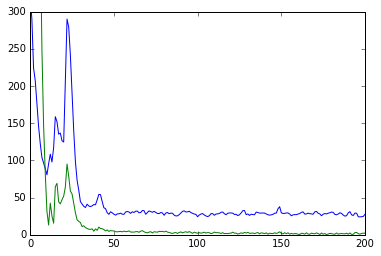

In [31]:
plt.plot(noise_spec)
plt.plot(np.abs(fft(new_dark)))
plt.ylim((0,300))
plt.xlim((0,200))

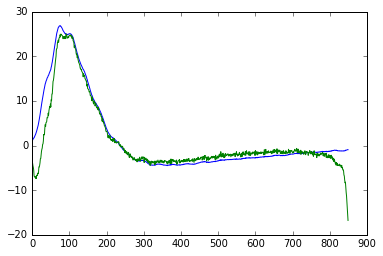

In [32]:
dsp_wind=np.hamming(850)
eps=1e-6
ndft=fft(new_dark*dsp_wind)
ndm=ifft(ndft/noise_spec)/(dsp_wind+eps)
plt.plot(new_dark)
plt.plot(np.real(ndm)*25/np.max(np.real(ndm)))
#test_filt=ff.prony_shank(np.real(ndm),16,16,sForm=10,unitize=True)
#plt.plot(test_filt.filter(imp))

While this waveform may work for a matched filter, it is not compatible with the prony analysis method. However looking at the noise spectrum it can be observed that the primary componenent of the noise peaks at x=21. An improved pulse finder could be built by prefiltering the samples digitally to remove this ringing. 

In [33]:
pcb,pca=fi.signal.iirfilter(4,.055,btype="lowpass",ftype="cheby2",rs=60)
lpb,lpa=fi.signal.iirfilter(4,.001,btype="highpass",ftype="butter")
prefilt=lambda x:fi.signal.filtfilt(lpb,lpa,fi.signal.filtfilt(pcb,pca,x))
filt_finder=fi.pulse_finder(f_test,old_read=False,filt_func=prefilt)

In [34]:
#this cell is slow to run
gen_filt_dark=False
if gen_filt_dark:
    test_dat_reader=fi.reader(data_dir+'wave280.txt',20000)
    filt_dark=fi.re_average(test_dat_reader,filt_finder,1000,limit=25.0)
    test_dat_reader.close()
    t_f_wav=pg.f_wav(data_dir+"filt_low_stat_280_pulse.txt")
    t_f_wav.write(filt_dark)
else:
    t_f_wav=pg.f_wav(data_dir+"filt_low_stat_280_pulse.txt")
    filt_dark=t_f_wav.read()

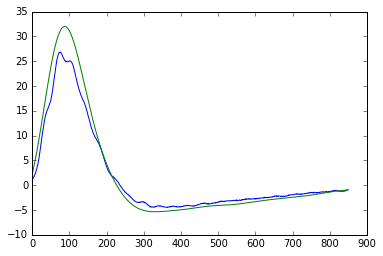

In [35]:
_=plt.plot(new_dark)
_=plt.plot(filt_dark)

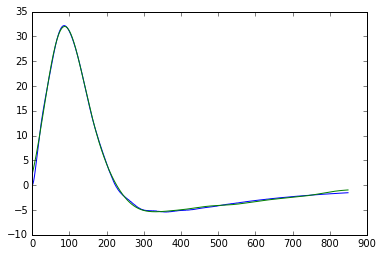

In [36]:
_=plt.plot(ff.prony_shank(filt_dark,12,12,sForm=10).filter(imp))
_=plt.plot(filt_dark)

In [37]:
filt_finder=fi.pulse_finder(data_dir+"filt_low_stat_280_pulse.txt",filt_func=prefilt,old_read=False,pn=12,zn=12,sForm=10,skip=0,total_l=850)

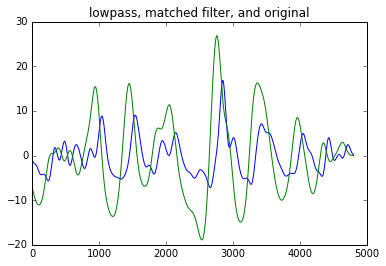

In [38]:
filt_finder.filter_sample(blocks[1],display=True)

In [39]:
find_filt_pulses=False
wnf=data_dir+"280_pulses_all_filtered_thinned_l5.txt"
if find_filt_pulses:
    test_dat_reader=fi.reader(data_dir+'wave280.txt',20000)
    filt_finder.get_all_pulse(test_dat_reader,wnf,display=True,block_time=900,limit=5)
    test_dat_reader.close()

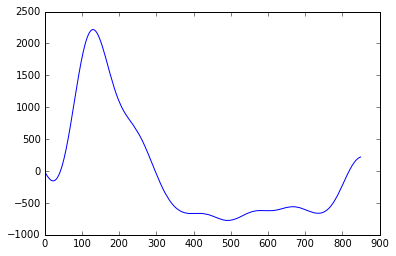

In [40]:
inter=lambda x:map(lambda y:int(y),x)
with open(wnf) as f:
    evs=[]
    for i in xrange(10):
        x=f.readline()
        evs.append(inter(x.split(' ')))
_=plt.plot(evs[0])

In [41]:
%%cache fspec.pkl fspec
fspec=fi.spectrum(wnf,filt_finder.ef)

[Skipped the cell's code and loaded variables fspec from file '/home/ryan/Desktop/pulse/pulse model/fspec.pkl'.]


In [42]:
_=plt.hist(fspec,bins=100)
print len(fspec)

34341


In [43]:
new_fn=data_dir+"wave_290_ExternalTrigger_1Meg_10nF.txt"
sh_evn_fn=data_dir+"wave_290_thinned_events.txt"

In [44]:
tr=fi.reader(new_fn,20000)
s1=tr.get_block()
tr.close()
#nfinder.filter_sample(s1[:5000],display=True)
plt.figure(figsize=(12,5))
plt.title("High passed Waveform, Matched Filter")
tsig=nfinder.filt_func(s1[:5000])
plt.plot(range(0,10000,2),tsig,label="Highpassed Waveform")
plt.plot(range(0,10000,2),np.flip(nfinder.iir_filt.filter(np.flip(tsig,0)),0),label="Matched Filter Output",linewidth=2)
plt.xlabel("Time ns")
plt.ylabel("Filter Output arb. units")
plt.ylim((-25,40))
plt.legend()


Looking at the above we can see that nearby dark counts do not fully resolve in the matched filter curve. While the matched filter maximizes energy at the peak it also has a support twice as wide as the signal of interest. 

In [45]:
shield_events=False
if shield_events:
    tr=fi.reader(new_fn,20000)
    nfinder.get_all_pulse(tr,sh_evn_fn,limit=5,lower=2,block_time=900,display=True)
    tr.close()

In [46]:
%%cache sspect.pkl sspect
sspect=fi.spectrum(sh_evn_fn,efunc2)

[Skipped the cell's code and loaded variables sspect from file '/home/ryan/Desktop/pulse/pulse model/sspect.pkl'.]


In [47]:
_=plt.hist(sspect,bins=100)

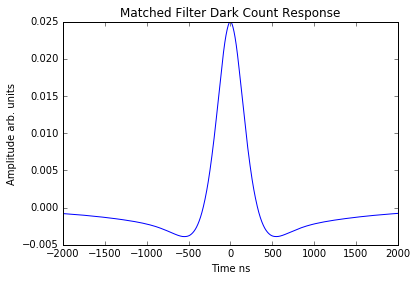

In [48]:
_=plt.plot(range(-4000,4001,2),nfinder.iir_filt.filter(np.flip(nfinder.iir_filt.filter(np.asarray([0]*2000+[1]+[0]*2000)),0)))
_=plt.xlim((-2000,2000))
_=plt.xlabel("Time ns")
_=plt.ylabel("Amplitude arb. units")
_=plt.title("Matched Filter Dark Count Response")

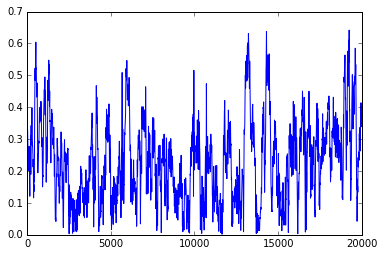

In [49]:
_=plt.plot(np.abs(ifft(fft(s1)/np.interp(range(20000),range(850),fft(new_dark)+20))))

In [194]:
def cmat(a,s,l,cv):
    vl=len(cv)
    cv=np.correlate(cv,cv,"full")[vl-1:]
    wmat=np.zeros((vl,vl))
    wmat[0,:]=cv
    wmat[:,0]=cv
    wmat=(a-a**2)*wmat
    wmat[0,0]+=s**2
    rmat=np.zeros((l,l))
    for n in xrange(l):
        rmat[n:n+vl,n:n+vl]+=wmat[:min(vl,l-n),:min(vl,l-n)]
    return rmat

def filt(pulse,a,s,l):
    cormat=cmat(a,s,l,pulse)
    return np.dot(np.linalg.pinv(cormat),pulse[:l])

def feature_filt(pulse,dc_rate,std,tail_control,l,fd=3):
    cor_mat=cmat(dc_rate,std,l,pulse)
    #tcv=tail_control*fd/(float(l+fd)-np.arange(l))
    #cor_mat+=np.outer(tcv,tcv)
    cor_mat+=tail_control*np.diag(np.arange(l)**2)
    lagr_vec=np.append(np.ones(l).reshape((-1,1)),np.arange(l).reshape((-1,1)),1)
    cor_mat=np.append(cor_mat,lagr_vec,1)
    v1=l*(l-1)/2
    v2=v1*(2*l-1)/3
    lagr_vec=np.append(lagr_vec,np.asarray([[l,v1],[v1,v2]]),0)
    cor_mat=np.append(cor_mat,lagr_vec.T,0)
    #print(cor_mat[-4:,-4:])
    wv=np.dot(np.linalg.pinv(cor_mat),np.append(pulse[:l],[0,0]))
    wvt=wv[:l]
    pc=wv[-2]
    lc=wv[-1]
    wvt+=np.dot(lagr_vec[:l],[pc,lc])
    return wvt

wc=filt_finder.iir_filt.filter(np.asarray([1]+[0]*1999))
g=filt(wc,.01,.05,600)
ng=feature_filt(wc,.01,.05,.000001,600)

In [286]:
print np.sum(ng), np.sum(np.arange(600)*ng)

-1.58884461143316e-10 -9.395080269314349e-09


<IPython.core.display.Javascript object>


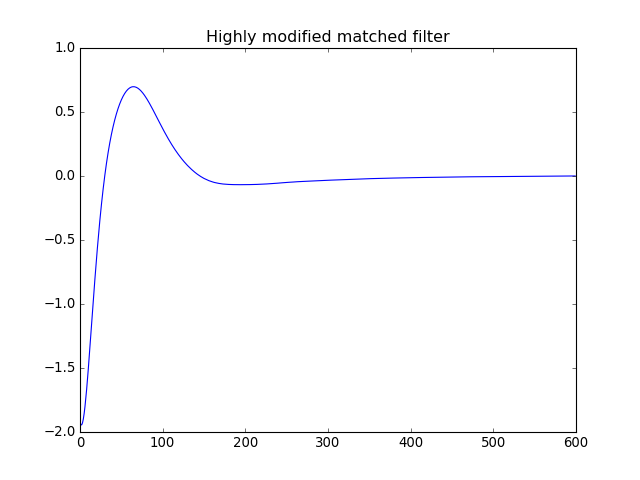

In [280]:
plt.plot(feature_filt(wc,.01,.05,.000001,600))
plt.title("Highly modified matched filter")
#plt.plot(feature_filt(wc,.001,.1,10000,600,fd=50))
#plt.plot(feature_filt(wc,.01,.05,1000,300,fd=10))

<IPython.core.display.Javascript object>


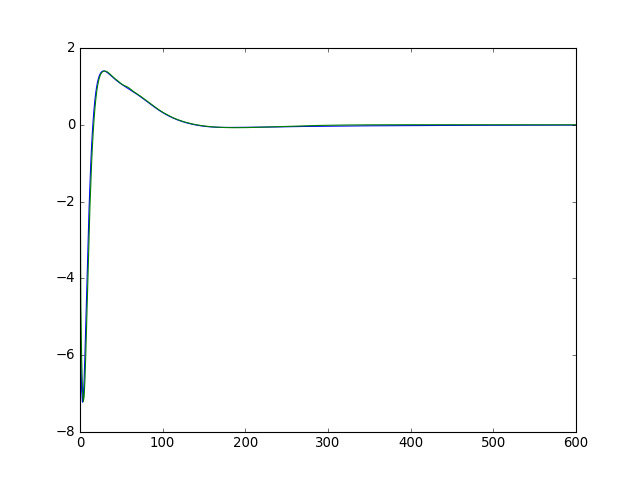

In [292]:
ng=feature_filt(wc,.01,.01,.000001,600)
plt.plot(ng)
mmf=ff.prony_shank(np.append(np.zeros(1),np.append(ng,np.zeros(400))),14,14,sForm=5)
plt.plot(mmf.filter(np.asarray([1]+[0]*600)))

<IPython.core.display.Javascript object>


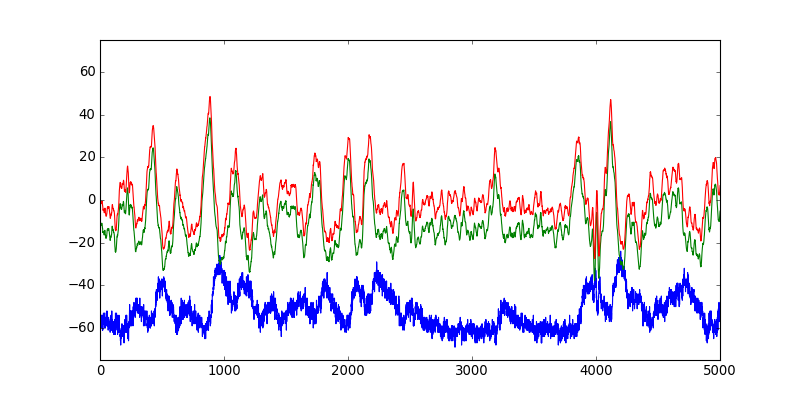

In [301]:
_=plt.figure(figsize=(10,5))
_=plt.plot(np.asarray(pt))
_=plt.plot(np.flip(mmf.filter(np.flip(pt,0)),0)/30)
_=plt.plot(np.flip(np.convolve(np.flip(pt,0),ng,'valid'),0)/30)
#_=plt.plot(mmf.filter(pt)/30)
_=plt.xlim((0,5000))
_=plt.ylim((-75,75))

Prony Shank Method loses well conditioned no zero/first moment.

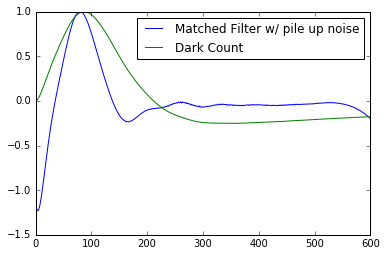

In [51]:
plt.plot(g/np.max(g),label='Matched Filter w/ pile up noise')
c=filt_finder.iir_filt.filter(np.asarray([1]+[0]*599))
plt.plot(c/np.max(c),label='Dark Count')
plt.legend()

In [52]:
fi.signal.find_peaks_cwt(s1,range(50,301,10),min_snr=.01)

/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/usr/local/lib/python2.7/dist-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


array([], dtype=float64)

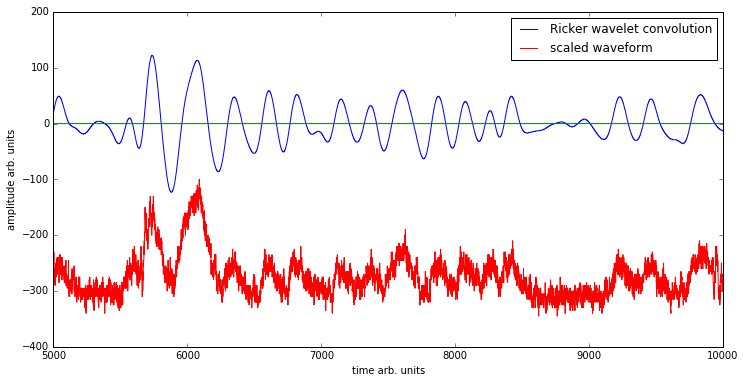

In [53]:
_=plt.figure(figsize=(12,6))
_=plt.plot(fi.signal.cwt(s1,fi.signal.ricker,[50]).T,label="Ricker wavelet convolution")
_=plt.plot(5*np.asarray(s1),color="red",label="scaled waveform")
_=plt.plot([0]*20000)
_=plt.xlim((5000,10000))
_=plt.ylabel("amplitude arb. units")
_=plt.xlabel("time arb. units")
_=plt.legend()

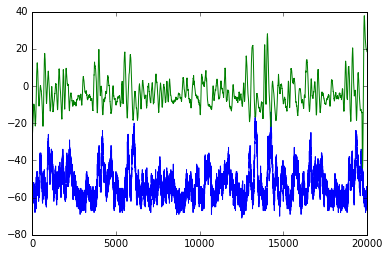

In [54]:
plt.plot(s1)
plt.plot(np.convolve(s1,g,'same')/50)

In [55]:
q=fi.signal.cwt(s1,fi.signal.ricker,[50]).reshape(-1)
parg=fi.signal.find_peaks_cwt(q,np.arange(5,30,2))

(0, 5000)

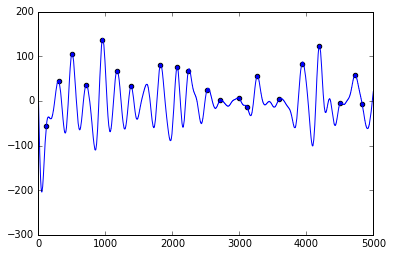

In [56]:
plt.scatter(parg,q[parg])
plt.plot(q)
plt.xlim((0,5000))

In [57]:
_=plt.plot(np.linspace(-5,5,200),fi.signal.ricker(200,20))
_=plt.title("Ricker Wavelet")
_=plt.xlim((-5,5))
_=plt.xlabel("Standard Deviations")
_=plt.ylabel("Ampltitude")

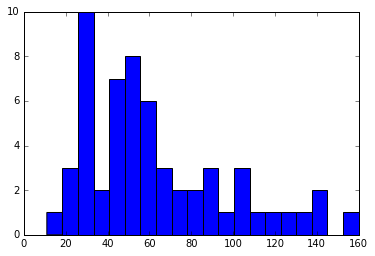

In [58]:
ps=q[parg]
ps=ps[ps>10]
_=plt.hist(ps,bins=20)

In [59]:
%%cache f_vals.pkl f_vals
%%capture
f_vals=np.zeros((0,0))
tr=fi.reader(new_fn,20000)
if not slow:
    runs=10
else:
    runs=1000
for i in xrange(runs):
    if tr.eof:
        break
    q=fi.signal.cwt(tr.get_block(),fi.signal.ricker,[50]).reshape(-1)
    parg=fi.signal.find_peaks_cwt(q,np.arange(5,30,2))
    ps=q[parg]
    ps=ps[ps>10]
    f_vals=np.append(f_vals,ps)
    sys.stdout.write(str(i)+'          \r')
    sys.stdout.flush()
tr.close()

[Skipped the cell's code and loaded variables f_vals from file '/home/ryan/Desktop/pulse/pulse model/f_vals.pkl'.]
test
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
24

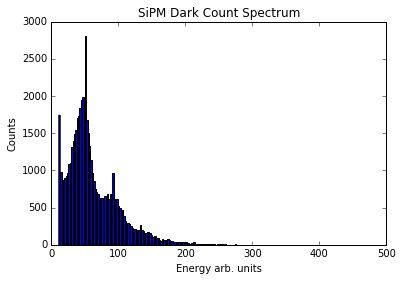

In [60]:
_=plt.hist(f_vals,bins=int(f_vals.shape[0]**.5))
_=plt.title('SiPM Dark Count Spectrum')
_=plt.xlabel('Energy arb. units')
_=plt.ylabel('Counts')

-0.01586429999464023


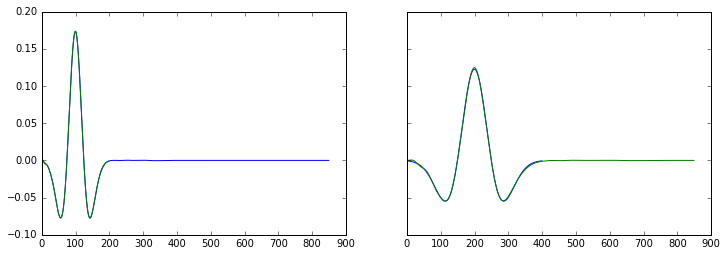

In [61]:
#plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
l=25
r=8
q=fi.signal.ricker(l*r,l)
#for n in range(4,12,2):
n=14
c=ff.prony_shank(np.append(q,np.zeros(400)),n,n,sForm=10)
f,ax=plt.subplots(1,2,sharey=True)
f.set_figwidth(12)
ax[0].plot(c.filter(imp))
ax[0].plot(q)
print np.sum(c.filter(imp))
#plt.xlim((0,189))

def coef_wavelet(l):
    qb=fi.signal.ricker(200,25)
    filt_base=ff.prony_shank(np.append(qb,np.zeros(400)),14,14,sForm=10)
    s=float(l)/25
    new_wav=fi.signal.ricker(12*l,l)[2*l:]
    filt_base.ac.slow(s)
    filt_base.bc=ff.shank_zeros(new_wav,14,filt_base.ac)
    return filt_base

w=coef_wavelet(50)
ax[1].plot(fi.signal.ricker(400,50))
ax[1].plot(w.filter(imp))

In [62]:
pt=s1
plt.plot(range(len(pt)),4*np.asarray(pt))
plt.plot(range(-100,len(pt)-100),c.filter(pt))
plt.plot(range(-200,len(pt)-200),w.filter(pt))
plt.xlim(0,5000)
plt.ylim((-300,150))

(-300, 150)

In [63]:
_=plt.plot(fi.signal.cwt(s1,fi.signal.ricker,[50]).T)
_=plt.plot(range(-200,len(pt)-200),w.filter(pt))
_=plt.xlim((0,5000))
wk=w.filter(pt)[200:5200]
spv=fi.schmidt_locater(wk,lower=9)
plt.scatter(spv,wk[spv])

In [64]:
%%capture
%%cache wspec.pkl tspec
runs=10000
wspec=fi.wave_spec(50,50)
tr=fi.reader(new_fn,20000)
tspec=wspec.read_spectrum(tr,runs)
tr.close()


In [65]:
_=plt.hist(tspec,bins=200)
_=plt.title("400ms of Data")
_=plt.xlim((0,300))

In [66]:
%%cache spec_list.pkl spec_list
spec_list=[]
runs=2000
for n in xrange(30,126,5):
    wspec=fi.wave_spec(n,n)
    tr=fi.reader(new_fn,20000)
    spec_list.append(wspec.read_spectrum(tr,runs))
    tr.close()
    print n
    

[Skipped the cell's code and loaded variables spec_list from file '/home/ryan/Desktop/pulse/pulse model/spec_list.pkl'.]
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125


currenty specs spans from 30 to 125 in steps of 5

In [67]:
model=GaussianMixture(n_components=4)
model.fit(np.asarray(tspec).reshape((-1,1)))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [68]:
def plot_mix(mix,xs):
    xs=xs.reshape((-1,1))
    acc=np.zeros(len(xs)).reshape((-1,1))
    ws=mix.weights_
    vs=mix.covariances_**.5
    for i,m in enumerate(mix.means_):
        acc+=ws[i]*norm.pdf(xs,loc=m,scale=vs[i])
    return acc

In [69]:
xs=np.linspace(-50,300,200)
q=plot_mix(model,xs)
_=plt.plot(xs,.9*2*len(tspec)*q/np.sum(q),linewidth=2)
_=plt.hist(tspec,bins=150,alpha=.5)
_=plt.title("Mixture of Gaussians")
_=plt.xlim((0,250))
_=plt.xlabel("Energy arb.units")
_=plt.ylabel("Counts")

In [70]:
model_list=[GaussianMixture(n_components=4) for i in xrange(len(spec_list))]
for i,spec in enumerate(spec_list):
    model_list[i].fit(np.asarray(spec).reshape((-1,1)))
    

In [71]:
def gen_reses(w_specs):
    ms=[GaussianMixture(n_components=4) for i in xrange(len(w_specs))]
    for i,spec in enumerate(w_specs):
        ms[i].fit(np.asarray(spec).reshape((-1,1)))
    reses=[[] for i in range(3)]
    for i,m in enumerate(ms):
        dats=zip(ms[i].covariances_,ms[i].means_)
        dats.sort(key=lambda x:x[1])
        for n in range(3):
            reses[n].append(dats[n+1][1]/dats[n+1][0]**.5)
    return reses

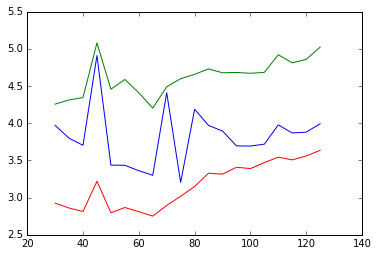

In [72]:
reses=[[] for i in range(3)]
for i,m in enumerate(model_list):
    dats=zip(model_list[i].covariances_,model_list[i].means_)
    dats.sort(key=lambda x:x[1])
    for n in range(3):
        reses[n].append(dats[n+1][1]/dats[n+1][0]**.5)
for n in range(3):
    plt.plot(range(30,126,5),np.asarray(reses[n]).reshape((-1,1)))

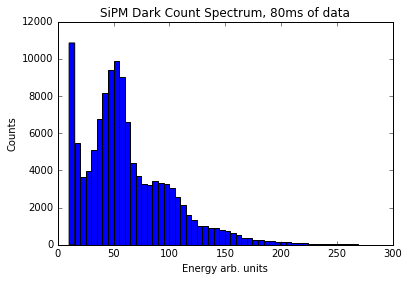

In [73]:
_=plt.hist(spec_list[4],bins=100)
_=plt.title("SiPM Dark Count Spectrum, 80ms of data")
_=plt.xlabel("Energy arb. units")
_=plt.ylabel("Counts")
_=plt.xlim((0,300))

In [74]:
%%cache ewav_specs.pkl ewav_specs
ewav_specs=[]
for n in xrange(30,61,3):
    wspec=fi.wave_spec(45,n)
    tr=fi.reader(new_fn,20000)
    ewav_specs.append(wspec.read_spectrum(tr,runs))
    tr.close()
    print n

[Skipped the cell's code and loaded variables ewav_specs from file '/home/ryan/Desktop/pulse/pulse model/ewav_specs.pkl'.]
30
33
36
39
42
45
48
51
54
57
60


In [75]:
ereses=gen_reses(ewav_specs)

In [76]:
for c in ereses:
    plt.plot(np.asarray(c).reshape(-1))

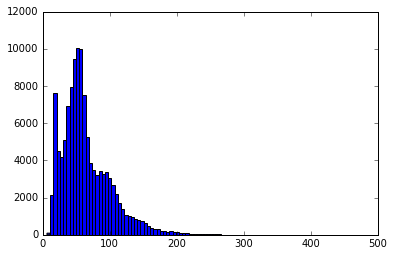

In [77]:
_=plt.hist(ewav_specs[6],bins=100)

In [78]:
_=plt.figure(figsize=(12,5))
_=plt.plot(range(0,40000,2),pt)
_=plt.xlabel("Time ns")
_=plt.title("SiPM Dark Count Wave Form")
_=plt.ylabel("Volts arb.units")


In [79]:
%%cache long_spec_2.pkl long_spec
runs=10000
wspec=fi.wave_spec(45,48)
tr=fi.reader(new_fn,20000)
long_spec=wspec.read_spectrum(tr,runs)
tr.close()

[Skipped the cell's code and loaded variables long_spec from file '/home/ryan/Desktop/pulse/pulse model/long_spec_2.pkl'.]


In [80]:
lmodel=GaussianMixture(n_components=4)
lmodel.fit(np.asarray(long_spec).reshape((-1,1)))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [81]:
print lmodel.means_
print lmodel.covariances_**.5

[[ 27.49857138]
 [ 93.20821931]
 [140.54207498]
 [ 53.73337146]]
[[[ 9.58001948]]

 [[17.46602501]]

 [[41.49714155]]

 [[10.15362957]]]


In [82]:
from matplotlib.patches import Rectangle
extra1 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
extra2 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
extra3 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

_=plt.hist(long_spec,bins=200)
_=plt.xlim((0,200))
_=plt.xlabel("Energy arb. units")
_=plt.ylabel("Counts")
_=plt.title("400ms of data")
_=plt.legend([extra1,extra2,extra3],["peak 1: $\mu= 54 $ $\sigma=10$",'peak 2: $\mu= 93 $ $\sigma=18$','peak 3: $\mu= 140 $ $\sigma=42$'])

In [282]:

mwspec=fi.wave_spec(20,20,mmf)
tr=fi.reader(new_fn,20000)
mmf_spec=mwspec.read_spectrum(tr,100,limit=150)
tr.close()

Need to investigate suitability of the peak algo for this filter
---
could modify shank zero to allow for natural preservation of baseline correction

In [283]:
_=plt.hist(mmf_spec,bins=100)
_=plt.xlim((0,1500))